# Clust default normalization

1. Take median between replicates
2. Default normalization: quantile normalization -> log2 transformation -> z-score normalization

## Quantile normalization

Is a global, i.e., sample-wise, normalization technique aimed at removing technical variation between samples. It is based on the assumption that the distribution of expression values is similar across all samples. The method consists of the following steps: (1) sort the expression values for each gene in each sample; (2) compute the average expression value for each gene across samples; (3) replace the expression values for each gene in each sample with the average expression value for that gene across samples.

However, when the differences in the global distribution of expression values across samples is due to biological variation, quantile normalization is not a good idea, since it will remove biological variation.

Transcript / Cell - transform data shows large variation in the distribution of expression values across samples. Not sure this is due to biological variation or due to an artifact of the transformation.

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import sem

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK, add_pathways_to_deseq_df, show_pathways_in_ranked_genes

%matplotlib inline


root_dir = Path(os.getcwd())
results_dir = root_dir / "results"
data_dir = root_dir / "data"

In [2]:
def plot_density(df, ax=None, show_plot=True, title=None, show_legend=False):
    sns.set(style="whitegrid")
    if ax is None:
        fig, ax = plt.subplots()

    qn_df = quantile_normalize(df)
    qn_sample = qn_df.iloc[:, 0]

    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            sns.kdeplot(df[column], label=column, ax=ax, alpha=1)

    sns.kdeplot(qn_sample, label='Quantile Normalized', ax=ax, alpha=0.5, color='black', lw=2.8)
    if show_legend:
        ax.legend()
    ax.set_xlabel('log2(expression)')
    ax.set_ylabel('Density')
    if title is not None:
        ax.set_title(title)
    if show_plot:
        plt.show()
    return ax


def take_average_values(df, method="median"):
    index_name = df.index.name
    df_long = df.reset_index().melt(id_vars=index_name, var_name='Column', value_name='Value')
    df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
    df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

    if method == "mean":
        aggregated_values = df_long.groupby([index_name, 'Temperature'])['Value'].mean().reset_index()
    elif method == "median":
        aggregated_values = df_long.groupby([index_name, 'Temperature'])['Value'].median().reset_index()
    else:
        raise ValueError("Invalid method. Please use 'mean' or 'median'.")

    return aggregated_values.pivot_table(index=index_name, columns='Temperature', values='Value')


def z_normalize(df):
    return df.apply(lambda x: (x - x.mean()) / x.std(ddof=0), axis=1)


def log2_normalize(df):
    return df.applymap(np.log2)


def quantile_normalize(df):
    rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()
    return df.rank(method='min').stack().astype(int).map(rank_mean).unstack()

## Load counts

In [3]:
min_count = 10

counts = pd.read_csv(data_dir / 'DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)

Text(0, 0.5, 'Median counts')

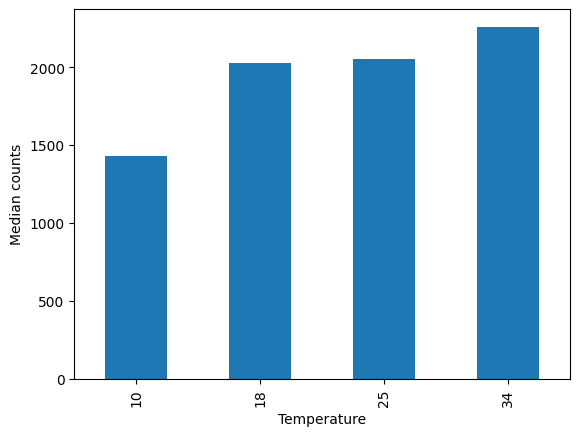

In [4]:
ax = take_average_values(counts.set_index("index")).median().plot(kind='bar')
ax.set_xlabel('Temperature')
ax.set_ylabel('Median counts')

## Get Transcript / Cell from Abundance Data

In [5]:
volume_meta = pd.read_excel(data_dir / "Laura_Normalization" / "Datos_Dokdonia_9Jun23.xlsx")
volume_meta["Sample"] = volume_meta['Light/Dark'] + '_' + volume_meta['Temperature'].astype(str) + '_' + volume_meta['Replicate']
volume_meta.head()

,Temperature,Light/Dark,Replicate,Total biovolume (um3),Total abundance (cells),Avg_Standard_ratio,Sample
0,10,L,R1,2.294207e+08,7.609607e+08,7128.171978,L_10_R1
1,10,L,R2,1.803365e+08,5.434251e+08,22976.436275,L_10_R2
2,10,L,R3,1.960539e+08,6.095364e+08,20778.875834,L_10_R3
3,10,D,R1,1.841892e+08,5.789344e+08,12210.079577,D_10_R1
4,10,D,R2,1.900776e+08,5.737051e+08,18207.999370,D_10_R2


In [6]:
TC_new, TV = DE.get_transcripts_volume(counts, volume_meta, ["D_25_R1"])
TC_new = TC_new.set_index("index")
TV = TV.set_index("index")

/tmp/ipykernel_20068/1113300778.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = volume_meta.groupby('Temperature').mean()


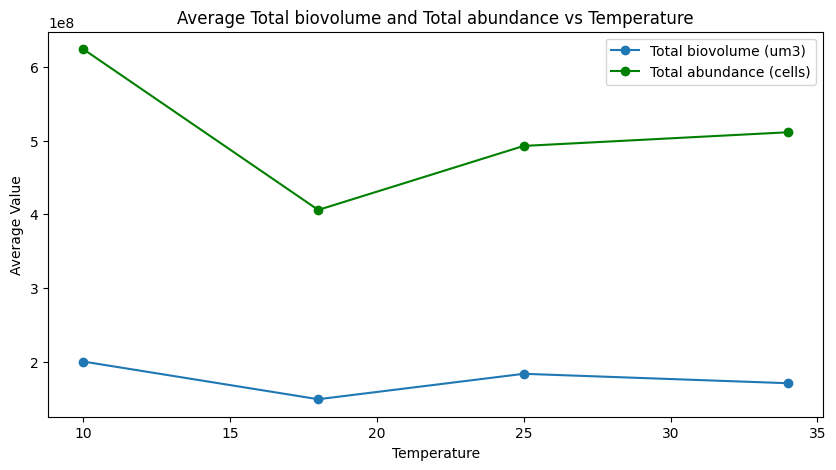

In [7]:
import matplotlib.pyplot as plt

# Group the data by 'Temperature' and calculate the mean
grouped = volume_meta.groupby('Temperature').mean()

# Create a new figure
plt.figure(figsize=(10, 5))

# Plot the average 'Total biovolume' for each 'Temperature'
plt.plot(grouped.index, grouped['Total biovolume (um3)'], marker='o', label='Total biovolume (um3)')

# Plot the average 'Total abundance' for each 'Temperature'
plt.plot(grouped.index, grouped['Total abundance (cells)'], marker='o', color='green', label='Total abundance (cells)')

plt.title('Average Total biovolume and Total abundance vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Average Value')
plt.legend()

# Show the plot
plt.show()


There were more cells at 10 degrees. The question is: the sample that was sequenced contained the same amount of RNA than the other ones or was it measured by volume of culture media instead of total RNA? That is, was this size effect taken into account prior to sequencing?

__UPDATE__

Alright, after ploting total counts per each temperature, we can see that at 10 degrees there are _less_ total counts AND also more cells! So even less total RNA per cell than in other samples. Hence, when correcting by number of cells, expression values get really low at 10 degrees. This could actually be a biological effect, so cells at 10 degrees are really struggling to express their genes (or being more efficient doing it).

DeSeq2 internally corrects for library size, but obviously is oblivious to the large number of cells at 10 degrees and does not take this into account (only the library size.). This could explain the differences we were observing between temperatures and methods.

This assuming that the same volume of culture media was used to collect RNA from all samples.

__Question__

Cell abundance was measured from the final culture media that was filtered to extract RNA?

Refs:

https://www.biostars.org/p/9551775/

http://bioconductor.org/books/3.14/OSCA.basic/normalization.html

http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#why-un-normalized-counts:~:text=Input%20data-,Why%20un%2Dnormalized%20counts%3F,-As%20input%2C%20the

## Compute only counts scaled by average internal standard and by abundance

In [8]:
abundance_meta = pd.read_excel(data_dir / "Laura_Normalization" / "Abundancias_Dokdonia.xlsx")
counts_IS = DE.scale_counts_by_internal_standard(counts, abundance_meta)

## Get DeSeq2 normalized counts

In [9]:
# Deseq2 normalization
colfactor = pd.DataFrame(
    {'Sample': counts.columns, 'Temperature': counts.columns.str.extract(r'_(\d+)_', expand=False)}
    ).iloc[1:, :].set_index('Sample', inplace=False)
colfactor.head()

deseq2_counts = DE.deseq2Normalize(counts, colfactor,
                gene_column="index",
                design_formula="~ Temperature")

INFO:DESeq2:Normalizing counts


Text(0, 0.5, 'Median DeSeq2-norm counts')

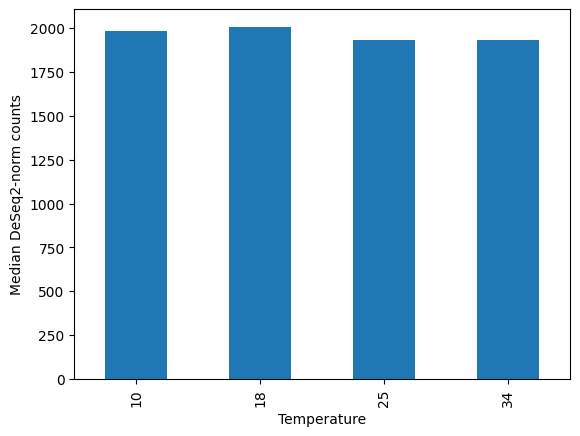

In [10]:
ax = take_average_values(deseq2_counts.set_index("index")).median().plot(kind='bar')
ax.set_xlabel('Temperature')
ax.set_ylabel('Median DeSeq2-norm counts')


## Get TPM values

In [11]:
# TPM-normalize count data
patric_file = pd.read_csv(data_dir / "Function_Annotations/PATRIC/Dokdonia_MED134_Craig_PATRIC_genome_feature.csv")
tpm = DE.tpmNormalize(counts, patric_file).set_index("index")

# Compare distributions

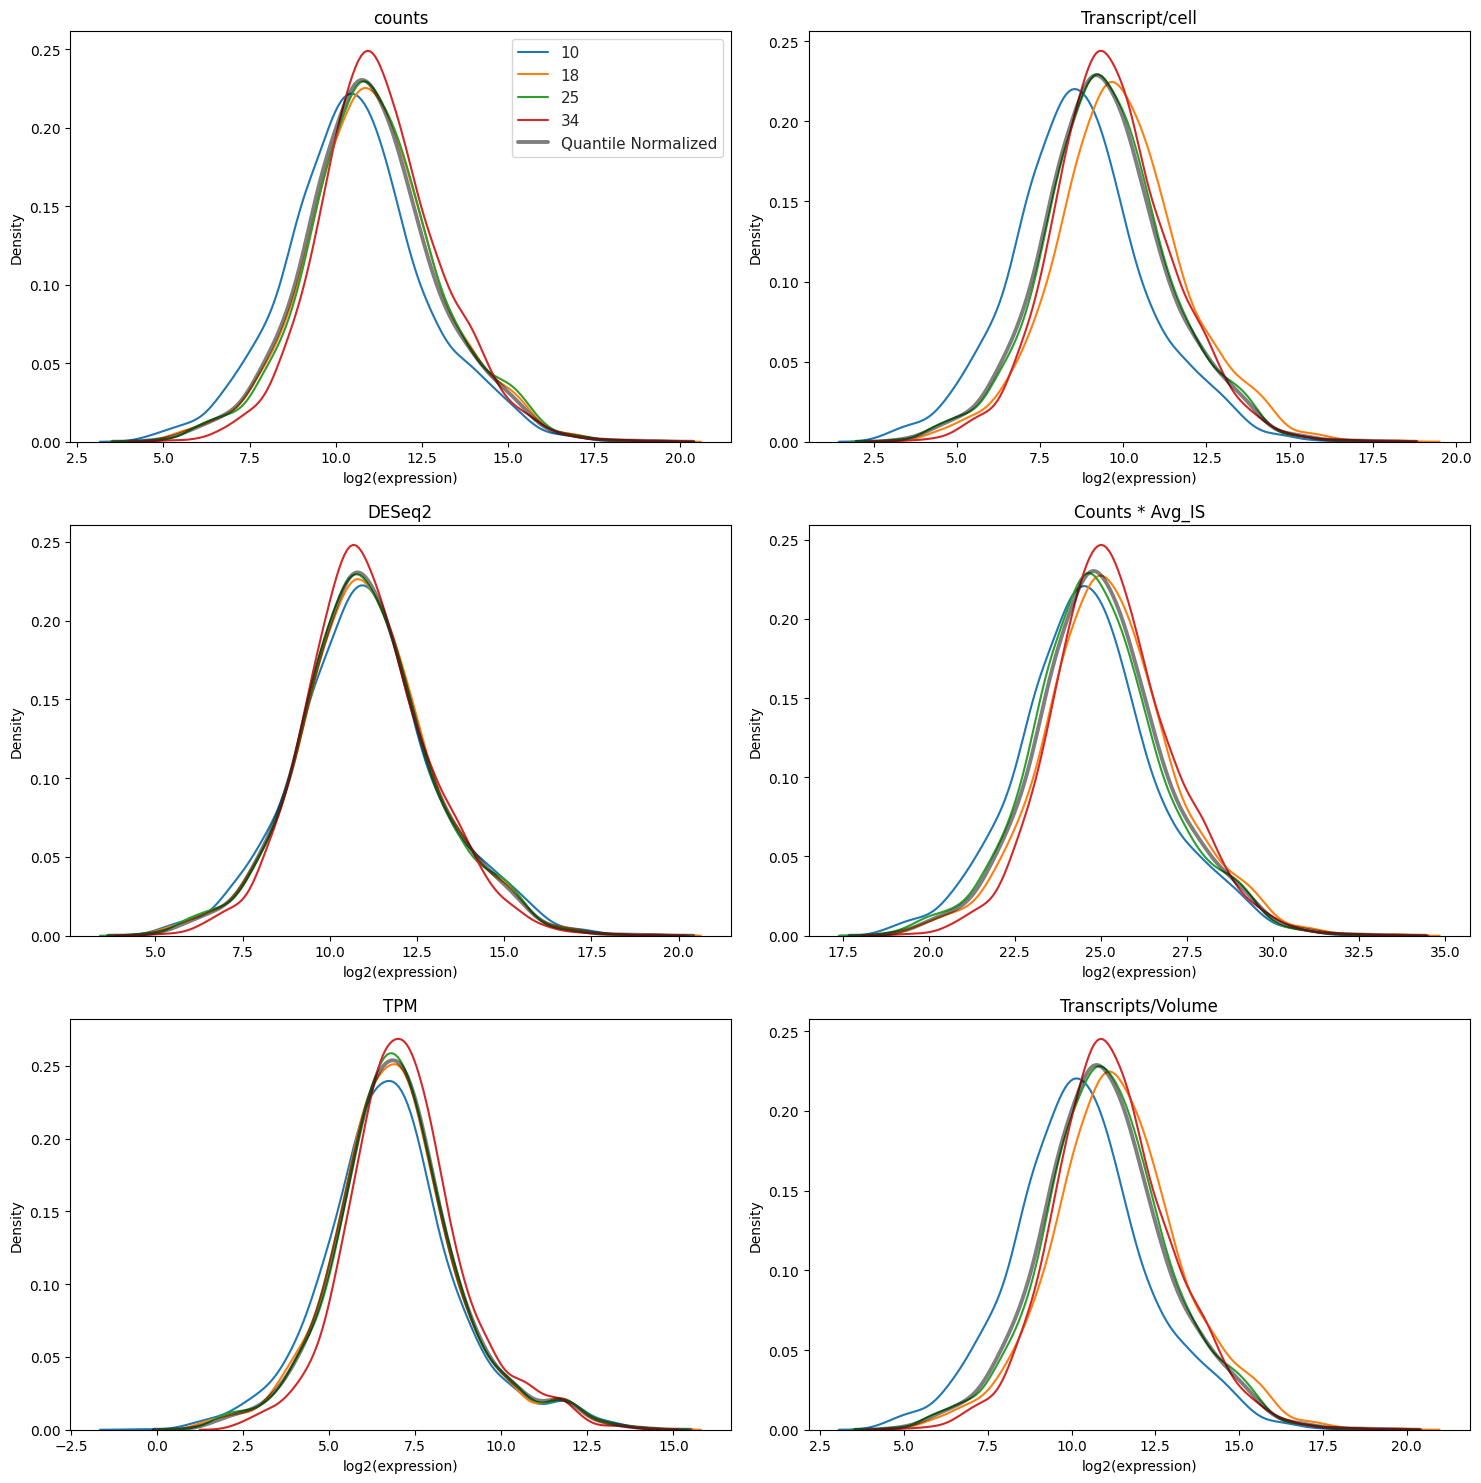

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

plot_density(log2_normalize(take_average_values(counts.set_index("index"))), ax=axs[0, 0], show_plot=False, title="counts", show_legend=True)
plot_density(log2_normalize(take_average_values(deseq2_counts.set_index("index"))), ax=axs[1, 0], show_plot=False, title="DESeq2")
plot_density(log2_normalize(take_average_values(TC_new * 1e4)), ax=axs[0, 1], show_plot=False, title="Transcript/cell")
plot_density(log2_normalize(take_average_values(tpm)), ax=axs[2, 0], show_plot=False, title="TPM")
plot_density(log2_normalize(take_average_values(counts_IS.set_index("index"))), ax=axs[1, 1], show_plot=False, title="Counts * Avg_IS")
plot_density(log2_normalize(take_average_values(TV * 1e4)), ax=axs[2, 1], show_plot=False, title="Transcripts/Volume")

plt.tight_layout()
plt.show()

In transcript / cell data, the distribution of expression values is quite different between samples. This is not the case for the DeSeq2 normalized counts or TPM values. Particularly, samples at 10º show lower expression values than the average, and samples at 18º higher expression values than the average. Thus, this variation is introduced by the transcript / cell transformation.

This observation also explains why the pattern showed in the clustering of transcript / cell data breaks down when quantile normalization is reversed.

Another point:

At 10 degrees, total RNA per cell is much lower than in other temperatures. Thus, when comparing gene expression across temperatures, gene expression will tend to be smaller at 10 for any gene. Is it fair to compare gene expression for a given gene across temperatures considering than the RNA pool per cell is smaller at 10? 

# Clustering with Transcripts / Volume

## Find  DE genes

In [13]:
gbk = GenomeGBK(data_dir / 'DokdoniaMED134.gbk')

KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
# gene_info = KEGGparser.getGeneInfoFromKEGGorthology()
gene_list = list(gene_pathways.keys())
print(f'There are a total of {len(gene_list)} genes')

There are a total of 785 genes


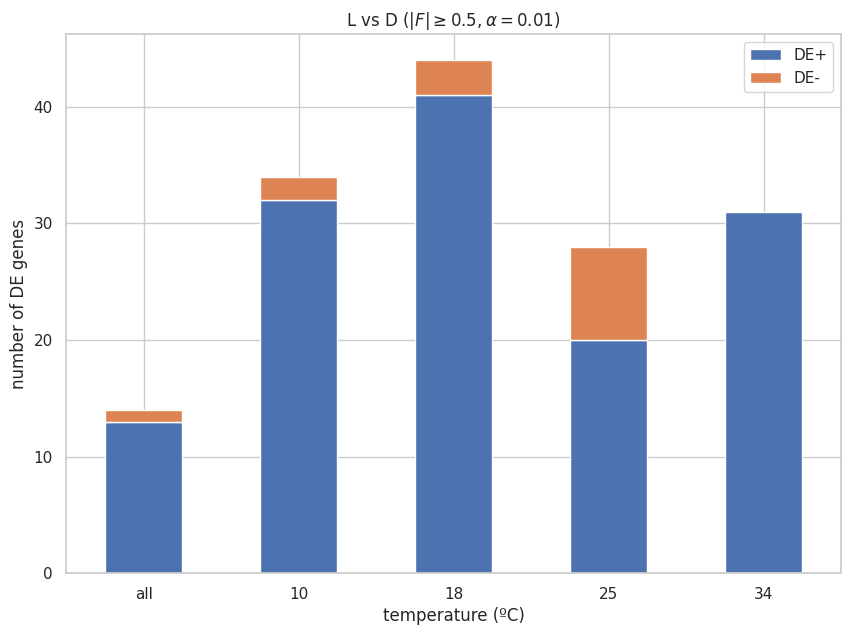

In [14]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = DE.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = DE.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L vs D ($|F|\\geq 0.5,\\alpha={p_value_cutoff}$)',
    figsize=(10, 7), ylabel='number of DE genes', xlabel='temperature (ºC)',
    rot=0)

In [15]:
from functools import reduce


DELD = {}
for T, res in L_D_res.items():
    DELD[T] = {
        'L>D': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange >= k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
        'D>L': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange <= -k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
    }

In [16]:
# Get light-dark DE genes at any temperature
k = 0.5
DE_all_T  = np.unique([g for g in L_D_res['all'][abs(L_D_res['all'].log2FoldChange) >= k].index]).tolist()
DE_plus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange >= k].index]).tolist()
DE_minus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange <= -k].index]).tolist()
DE_total = DE_plus + DE_minus
print(f'There are a total of {len(DE_total)} DE genes between Light and Dark')
print(f'There a total of {len(DE_all_T)} Light/Dark DE genes across the entire T range')

There are a total of 74 DE genes between Light and Dark
There a total of 14 Light/Dark DE genes across the entire T range


There are 1930 out of 2877 genes (67.08376781369482 %) which are DE across all temperature values


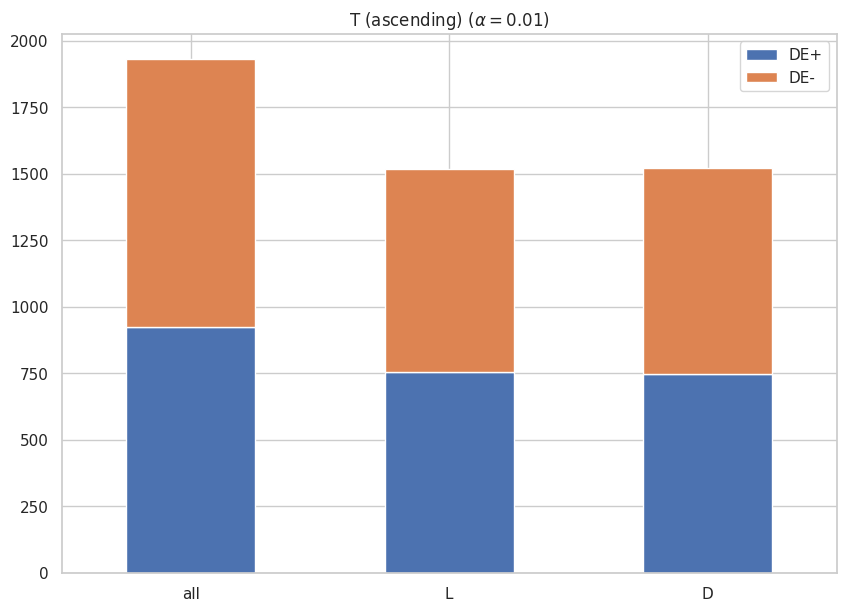

In [17]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = DE.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = DE.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')

# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

# Find genes which are DE across the temperature range
DE_genes_across_T = list(T_res["all"].index)
print(f"There are {len(DE_genes_across_T)} out of {counts.shape[0]} genes ({100 * len(DE_genes_across_T)/counts.shape[0]} %) which are DE across all temperature values")

## Remove Light/Dark DE genes from datasets

In [18]:
# Remove light-dark DE genes from TC dataset
TCnoDE = TC_new.loc[(
    (~TC_new.index.isin(DE_all_T)) #&
    # (TC_new.index.isin(DE_genes_across_T))
    )]

In [19]:
# Remove light-dark DE genes from TV dataset
TVnoDE = TV.loc[(
    (~TV.index.isin(DE_all_T)) #&
    # (TV.index.isin(DE_genes_across_T))
    )]

In [20]:
# Remove light-dark DE genes from counts
counts_noDE = counts.loc[(
    (~counts["index"].isin(DE_all_T)) #&
    # (counts["index"].isin(DE_genes_across_T))
    )]

In [21]:
# Remove light-dark DE genes from Deseq2 dataset
deseq2_counts_noDE = deseq2_counts.loc[(
    (~deseq2_counts["index"].isin(DE_all_T)) #&
    # (deseq2_counts["index"].isin(DE_genes_across_T))
    )]

In [22]:
counts_IS_noDE = counts_IS.loc[(
    (~counts_IS["index"].isin(DE_all_T)) #&
    # (counts_ID["index"].isin(DE_genes_across_T))
    )]

## Cluster TC data

In [23]:
# Using Transcripts/cell
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_NEW_TRANSCRIPT_CELL_ZSCORES'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_TCZ = CA.getGeneClusters(TCnoDE,path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization_only_zscores.txt',
                              replicates_file='clust_replicates_merged_L_D_volume.txt',
                              scaling_factor=1e5)

# Plot clusters
plot_cluster_data_TCZ = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Monday 03 July 2023 (15:17:10)                       |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

In [49]:
# VI.plotClusters(plot_cluster_data_TCZ, clusters_TCZ)

## Merge clusters

Merge into 3 groups. Also add a new cluster formed by the genes that correlate negatively with temperature.

There are a total of 1531 clustered genes


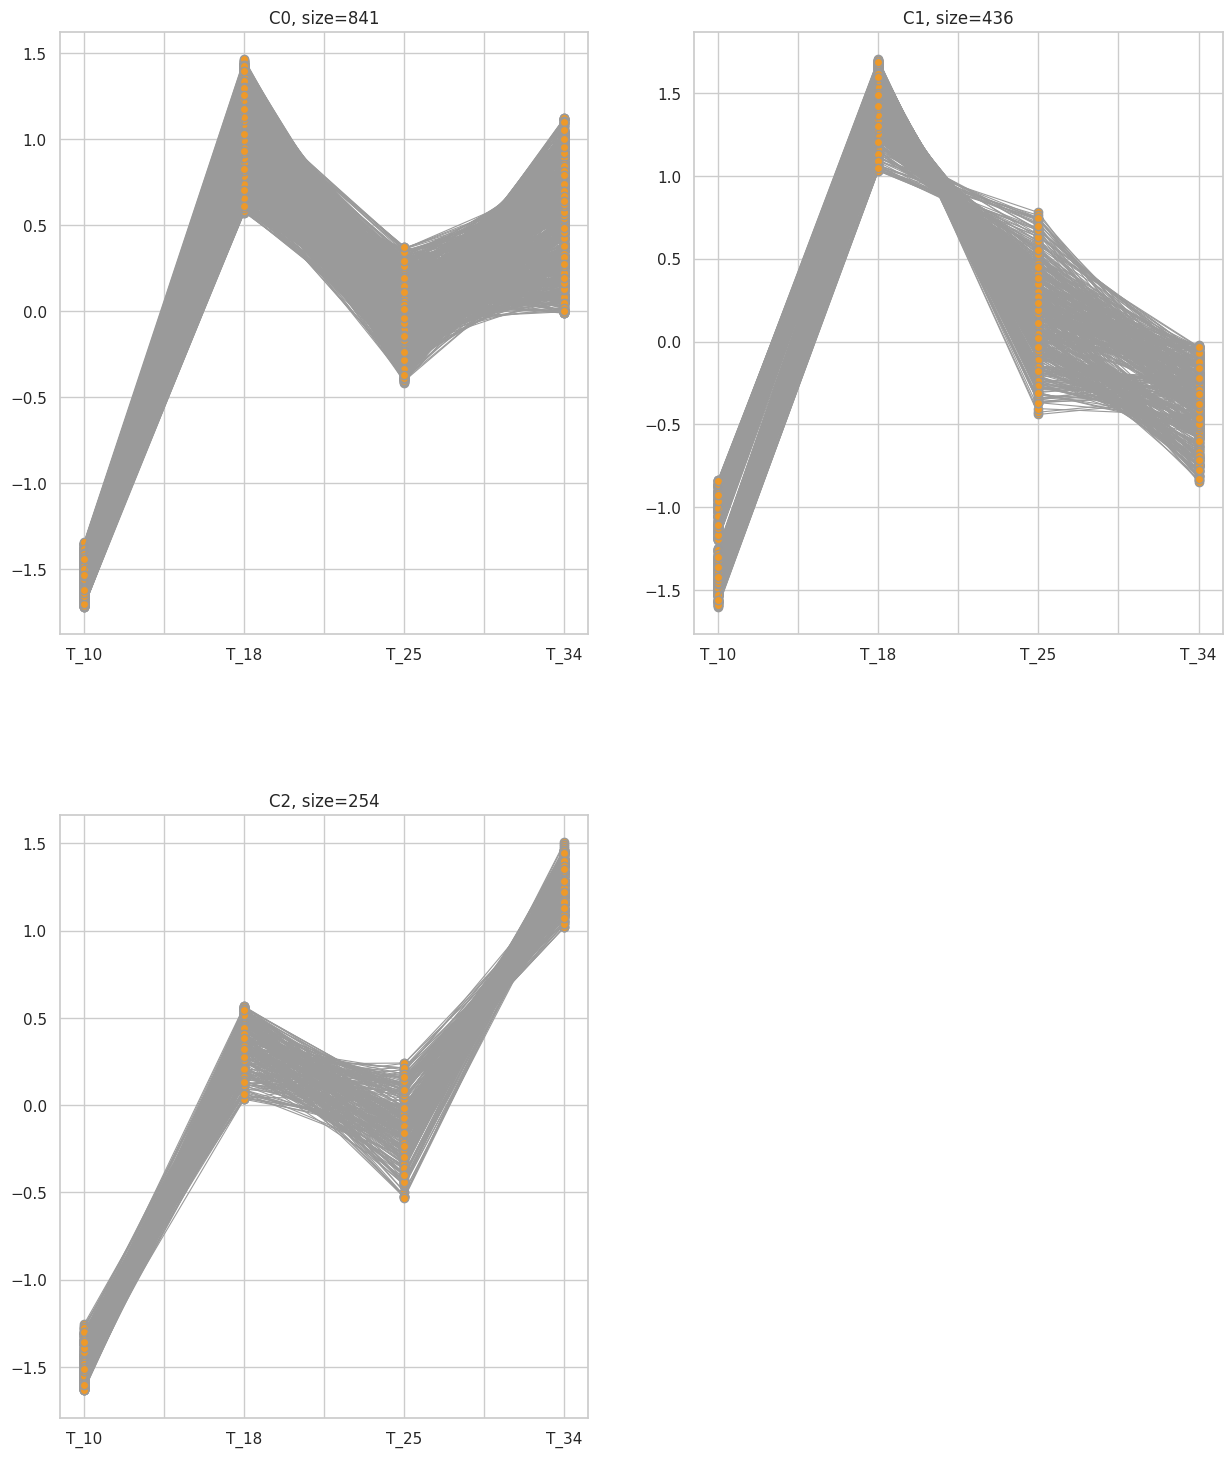

In [50]:
clusters_TCZ = {
    "C0": clusters_TCZ["C0"] + clusters_TCZ["C1"],
    "C1": clusters_TCZ["C2"] + clusters_TCZ["C3"],
    "C2": clusters_TCZ["C4"]
}

# Merge clusters in Clust output file
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in clusters_TCZ.items() ]))
df = df.applymap(lambda x: "" if pd.isna(x) else x)

with open(results_dir / "clust" / f"{res_id}/Clusters_Objects_merged.tsv", "w+") as file:
    file.write("\t".join([f"{k} ({len(v)} genes)" for k,v in clusters_TCZ.items()]) + "\n")
    file.write("\t".join(["Genes" for _ in clusters_TCZ]) + "\n")

    for row in df.values:
        file.write("\t".join(row) + "\n")

n_genes_in_clusters = sum([len(c) for c in clusters_TCZ.values()])
print(f"There are a total of {n_genes_in_clusters} clustered genes")

VI.plotClusters(plot_cluster_data_TCZ, clusters_TCZ)

## Annotate and rank genes within clusters

In [53]:
res_id = "CLUSTER_ONLY_TEMP_DE_GENES_NEW_TRANSCRIPT_CELL_ZSCORES"

cluster_data = (1 / 1e5) * pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Input_files_and_params/Data/clust_input.tsv'),
    sep='\t', index_col='index')
ranked_clusters_avg_expr = CA.rankGenesWithinClusters(clusters_TCZ, cluster_data, method="median")

In [54]:
if not (results_dir / "pathways").exists():
   (results_dir / "pathways").mkdir(exist_ok=False)

no_kegg_pathway = []
ranked_clusters = []
for cluster_id in ranked_clusters_avg_expr:
    ranked_df = show_pathways_in_ranked_genes(
        ranked_clusters_avg_expr[cluster_id],
        gbk, gene_pathways,
        gene_systems, n=None
        )
    no_kegg_pathway.append( 100 * (ranked_df[((ranked_df.subsystem.str.contains("Unspecified")) & ~ ranked_df.subsystem.isna())].shape[0]) / ranked_df.shape[0] )
    # ranked_df = ranked_df[~(
    #     (ranked_df["product"].str.contains("hypothetical")) &
    #     (ranked_df["subsystem"].str.contains("Unspecified"))
    #     )]
    ranked_df.insert(0, "cluster", cluster_id)
    ranked_df.to_csv(results_dir / "pathways" / f"ranked_{cluster_id}_TCZ.csv")
    ranked_clusters.append(ranked_df)

merged_ranked_clusters = pd.concat(ranked_clusters).sort_values(by="value", ascending=False)
merged_ranked_clusters.to_csv(results_dir / "pathways" / "ranked_clusters_TCZ.csv")
print(no_kegg_pathway)
print(np.mean(no_kegg_pathway))

[73.2461355529132, 68.34862385321101, 86.61417322834646]
76.06964421149023


## Cluster TV data

In [27]:
# Using Transcripts/cell
clust_tightness = 1
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_TRANSCRIPT_VOLUME_ZSCORES'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_TVZ = CA.getGeneClusters(TVnoDE,path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization_only_zscores.txt',
                              replicates_file='clust_replicates_merged_L_D_volume.txt',
                              scaling_factor=1e5)

# Plot clusters
plot_cluster_data_TVZ = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Monday 03 July 2023 (15:17:23)                       |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

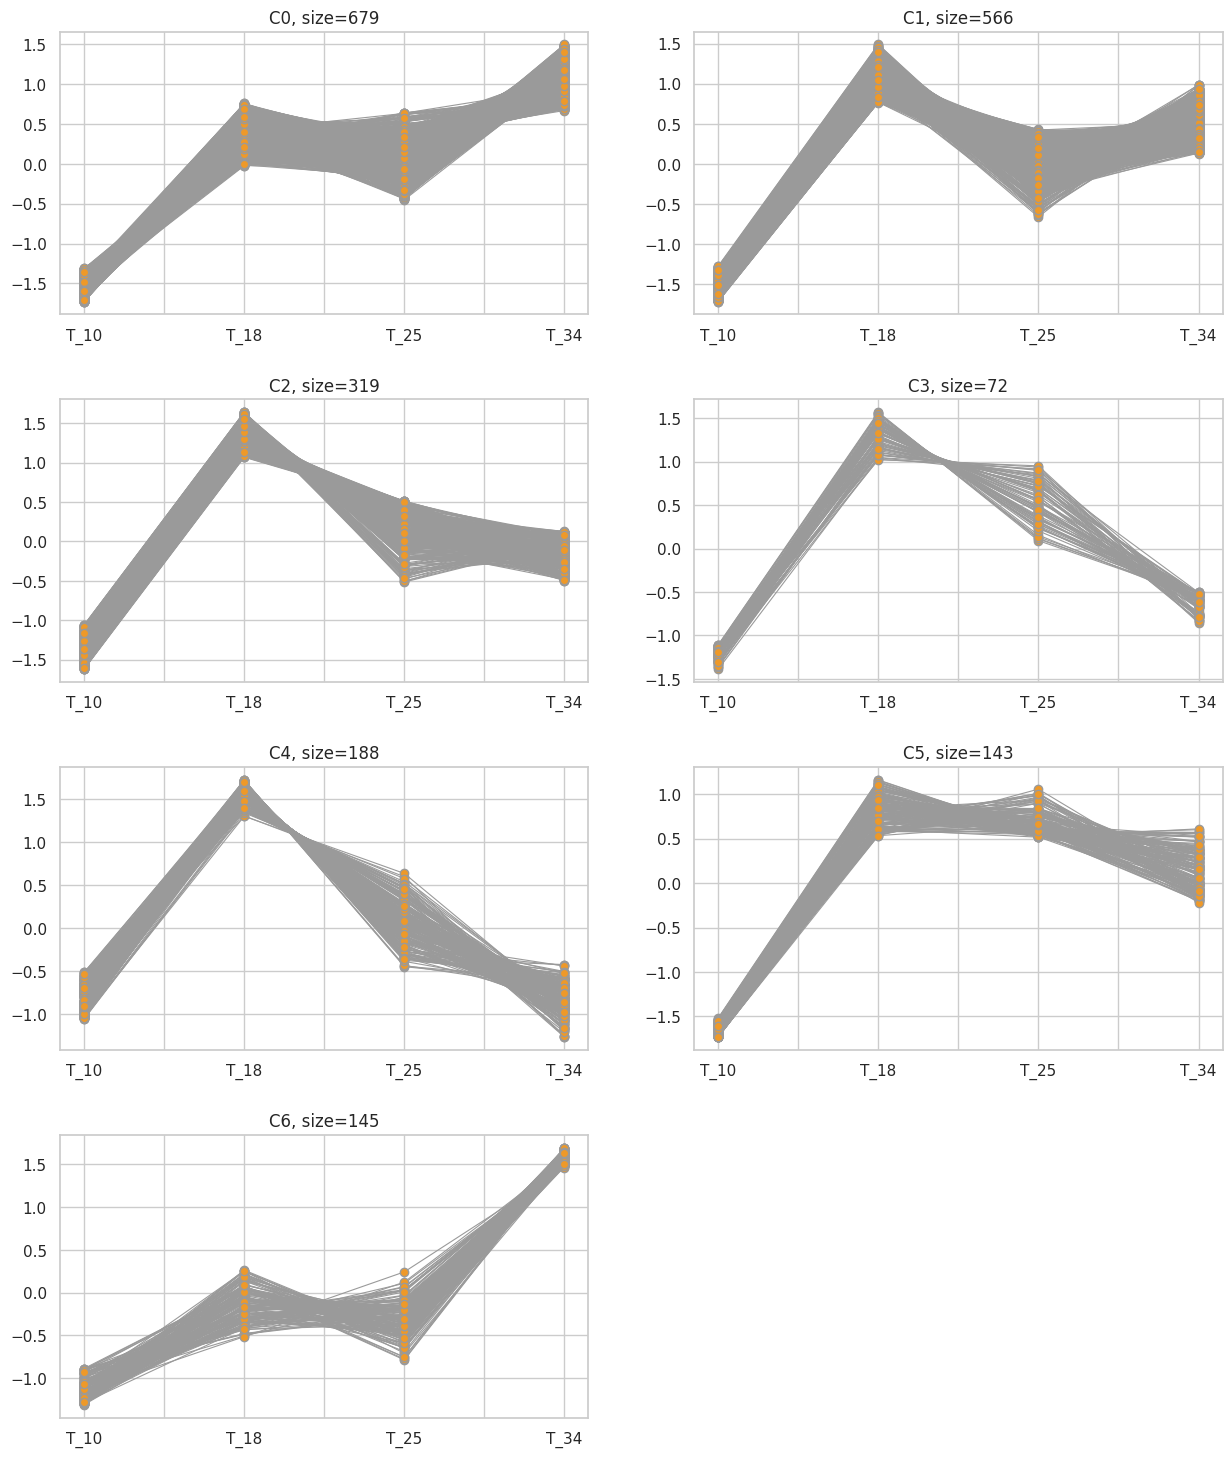

In [28]:
VI.plotClusters(plot_cluster_data_TVZ, clusters_TVZ)

## Comparing gene expression across temperatures after adjusting for cell abundance

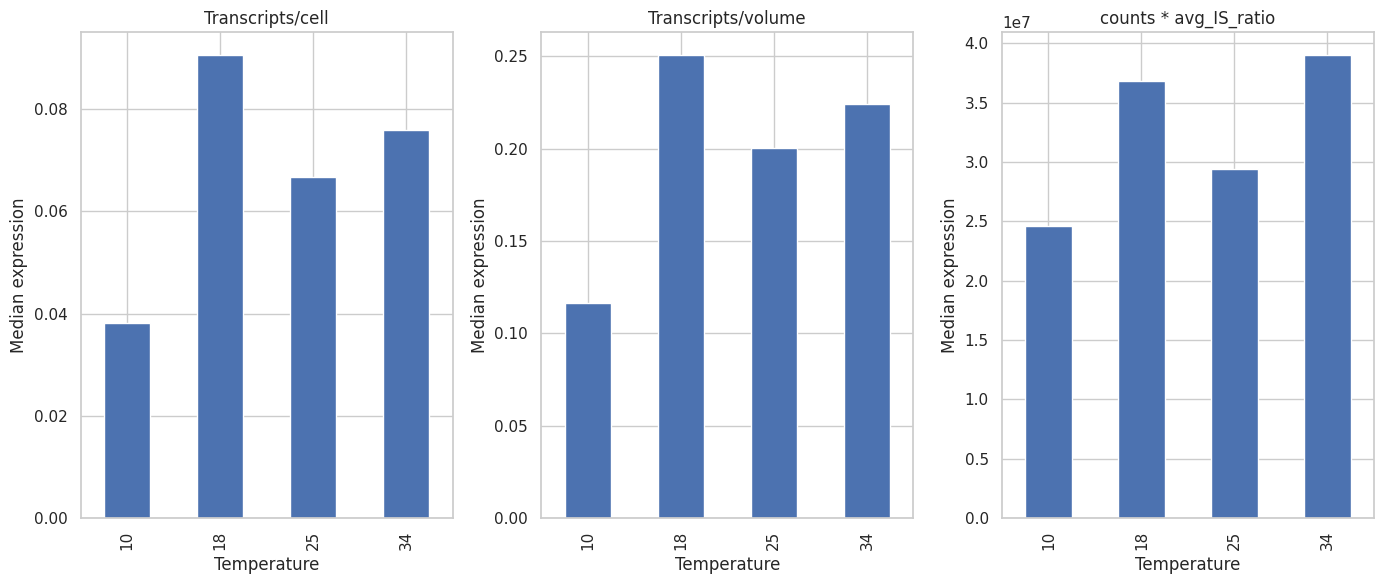

In [29]:
TC_avg = take_average_values(TC_new, method='median')
TV_avg = take_average_values(TV, method='median')
TC_avg_Z = z_normalize(take_average_values(TC_new, method='median'))
TV_avg_Z = z_normalize(take_average_values(TV, method='median'))
counts_IS_avg = take_average_values(counts_IS.set_index("index"), method='median')

# Plot total average expression across temperature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
ax = TC_avg.median().plot(kind='bar', ax=axes[0], title='Transcripts/cell')
ax.set_xlabel('Temperature')
ax.set_ylabel('Median expression')
ax1 = TV_avg.median().plot(kind='bar', ax=axes[1], title='Transcripts/volume')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Median expression')
ax2 = counts_IS_avg.median().plot(kind='bar', ax=axes[2], title='counts * avg_IS_ratio')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Median expression')
plt.tight_layout()
plt.show()

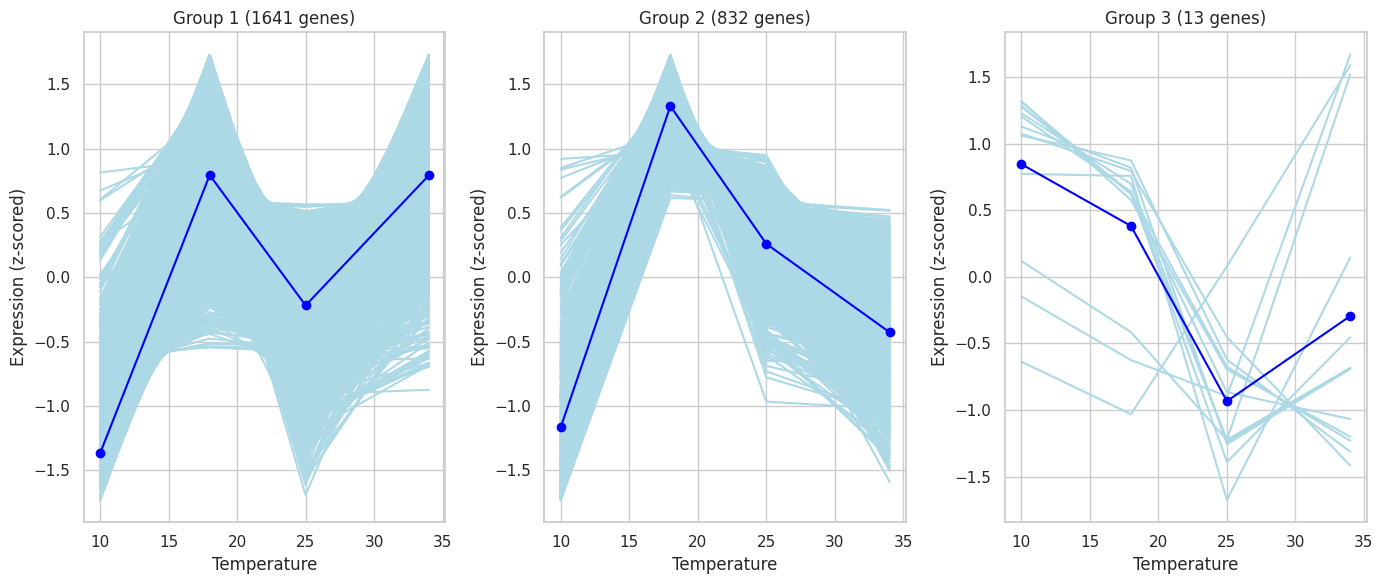

In [30]:
group1 = TV_avg_Z[(
    (TV_avg_Z[10] < TV_avg_Z[18]) &
    (TV_avg_Z[18] > TV_avg_Z[25]) &
    (TV_avg_Z[25] < TV_avg_Z[34])
    )]

# group2 = TV_avg_Z[TV_avg_Z[10] > TV_avg_Z[18]]
# group2 = TV_avg_Z[~TV_avg.index.isin(group1.index)]

group2 = TV_avg_Z[(
    (TV_avg_Z[10] < TV_avg_Z[18]) &
    (TV_avg_Z[18] > TV_avg_Z[25]) &
    (TV_avg_Z[25] > TV_avg_Z[34])
    )]

group3 = TV_avg_Z[TV_avg_Z[10] > TV_avg_Z[18]]


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

# Calculate mean for group 1
mean1 = group1.mean()

# Plot the data for each gene in group 1 on the first subplot
for index, row in group1.iterrows():
    axes[0].plot(row.index, row, color='lightblue')

# Plot the mean for group 1 on top
mean1.plot(ax=axes[0], color='blue', marker='o')

axes[0].set_title(f'Group 1 ({group1.shape[0]} genes)')
axes[0].set_ylabel('Expression (z-scored)')
axes[0].grid(True)

# Calculate mean for group 2
mean2 = group2.mean()

# Plot the data for each gene in group 2 on the second subplot
for index, row in group2.iterrows():
    axes[1].plot(row.index, row, color='lightblue')

# Plot the mean for group 2 on top
mean2.plot(ax=axes[1], color='blue', marker='o')

axes[1].set_title(f'Group 2 ({group2.shape[0]} genes)')
axes[1].set_ylabel('Expression (z-scored)')
axes[1].grid(True)


# Calculate mean for group 2
mean3 = group3.mean()

# Plot the data for each gene in group 2 on the second subplot
for index, row in group3.iterrows():
    axes[2].plot(row.index, row, color='lightblue')

# Plot the mean for group 2 on top
mean3.plot(ax=axes[2], color='blue', marker='o')

axes[2].set_title(f'Group 3 ({group3.shape[0]} genes)')
axes[2].set_ylabel('Expression (z-scored)')
axes[2].grid(True)

# Improve the layout
plt.tight_layout()
plt.show()

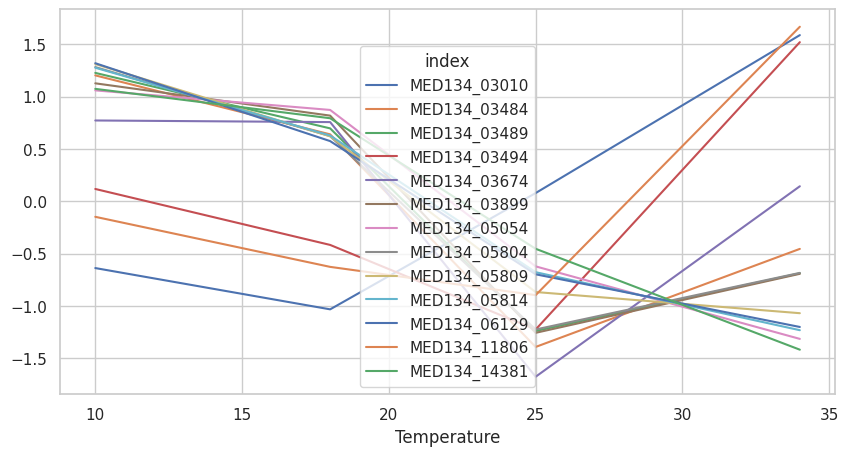

In [31]:
# Plot group 3
ax = group3.transpose().plot(legend=True, figsize=(10, 5))

In [32]:
downgenes = group3[(group3[10] > group3[18]) & (group3[18] > group3[25]) & (group3[25] > group3[34])]
downgenes

Temperature,10,18,25,34
index,,,,
MED134_05054,1.060706,0.873846,-0.620829,-1.313723
MED134_05809,1.312440,0.621722,-0.865909,-1.068253
MED134_05814,1.277211,0.629840,-0.676389,-1.230663
MED134_06129,1.320369,0.576015,-0.696503,-1.199881
MED134_14381,1.075212,0.794520,-0.452834,-1.416898


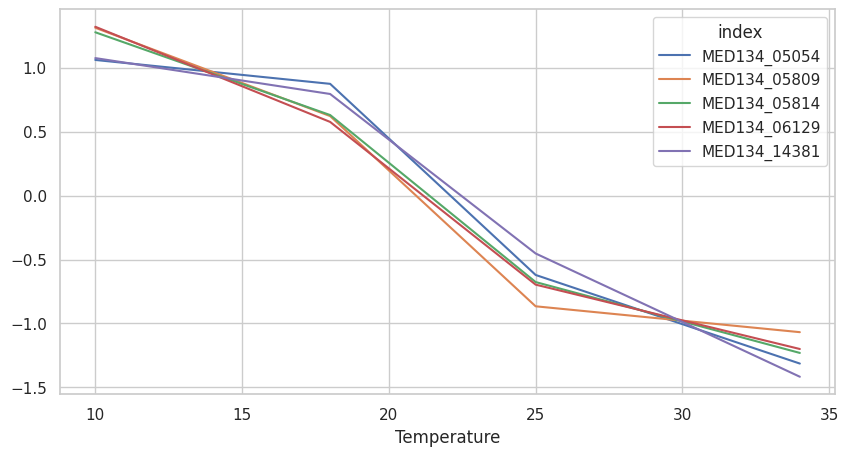

In [33]:
ax = downgenes.transpose().plot(legend=True, figsize=(10, 5))

In [34]:
for gene in downgenes.index:
    gene_info = gbk.getGeneInfo(gene)
    print(gene, gene_info["protein_id"], gene_info["product"], gene_info["location"])

MED134_05054 ['EAQ40094.1'] ['DEAD/DEAH box helicase'] [525959:527876](+)
MED134_05809 ['EAQ40245.1'] ['DEAD/DEAH box helicase'] [355210:356497](+)
MED134_05814 ['EAQ40246.1'] ['chaperone protein DnaJ'] [354717:355167](+)
MED134_06129 ['EAQ40309.1'] ['cold shock domain protein CspD'] [288928:289123](-)
MED134_14381 ['EAQ37935.1'] ['DEAD/DEAH box helicase'] [3196608:3197886](+)


## Compute TC expression ratios

In [35]:
ratio_10_34 = (TC_avg[10] / TC_avg[34])
ratio_10_25 = (TC_avg[10] / TC_avg[25])

# Print expression ratio for downgenes:
print('Gene', 'Ratio 10/34', 'Ratio 10/25')
for gene in downgenes.index:
    print(gene, ratio_10_34[gene], ratio_10_25[gene])

Gene Ratio 10/34 Ratio 10/25
MED134_05054 2.08697239724972 1.541293863655954
MED134_05809 2.8324405422453296 2.4292718971597234
MED134_05814 3.8338688451035616 2.4103709795662303
MED134_06129 10.893026140664553 3.267678101884469
MED134_14381 2.8129756148106613 1.6613892532584082


## DEAD/DEAH box helicases in bacteria

"Whereas in yeast most DEAD-box proteins are essential, no example of an essential bacterial DEAD-box protein has been reported so far; at most, their absence results in cold-sensitive growth."

" in E. coli (the bacterium where DEAD-box proteins have been mostly studied) their role is limited to ribosome biogenesis, mRNA degradation, and possibly translation initiation."

"The kinetic problem of RNA folding is dramatically aggravated at low temperatures. The physical basis for this aggravation is well known: RNA secondary and tertiary structures are mainly stabilized by cooperative polar interactions (as opposed to proteins where hydrophobic forces are important) whose breaking is characterized by high activation enthalpies. Consequently, the dissociation of these structures is drastically slowed at low temperatures."

"As an example, we have observed that the spontaneous dissociation of a 9 base-pair RNA duplex whose stability is typical of many helices from natural RNAs, occurs in less than 1 min at 37 °C but in about a year at 10 °C! However, this value is brought back to the minute range in the presence of the E. coli DEAD-box protein RhlE"

From [this paper](https://www.sciencedirect.com/science/article/pii/S1874939913000230)

[This other paper](https://www.tandfonline.com/doi/full/10.4161/rna.22638) also deals with helicases in cold adaptation in bacteria.

Very interesting that the genes that get the highest expression values at 10 degrees, even using transcript / cell!, are precisely those. Definitely involved in cold adaptation.

## DNAJ chaperone

Involved in protein synthesis, alleviating stabilization of unfolded proteins (prevent aggregation particularly important at low temperatures).

[This paper](https://www.sciencedirect.com/science/article/abs/pii/S0022283620303016)  talks about it
[Also this one](https://www.jbc.org/article/S0021-9258(18)46387-9/fulltext)

Basically, similar problem than with RNA. Polymers enter kinetically stable regions at low temperatures.

## Cold shock proteins

They seem to be also involved in binding DNA and RNA to prevent secondary structure stabilization at low temperatures.

[This paper talks about it](https://www.frontiersin.org/articles/10.3389/fmicb.2016.01151)
[Also this one](https://biosignaling.biomedcentral.com/articles/10.1186/s12964-018-0274-6)

## Why the weird peak at 18 degrees?

The behavior at 10 degrees is expected, but why would transcription increase at 18 degrees to decrease again at  25 to increase again at 34? Perhaps an artifact of biomass / biovolume measurements?

## NOTES

The question is: do we want to compare absolute expression values across temperatures or relative values which are corrected by library size and cell abundance?

In the first case, almost all genes follow the first pattern above, i.e., expression values are lower at 10 degrees and higher at 18 degrees. This is because there is less total RNA per cell at 10 degrees. Thus, when comparing gene expression across temperatures, gene expression will tend to be smaller at 10 for any gene. Is it fair to compare gene expression for a given gene across temperatures considering than the RNA pool per cell is smaller at 10?

## Genes with downward pattern using Deseq2 data

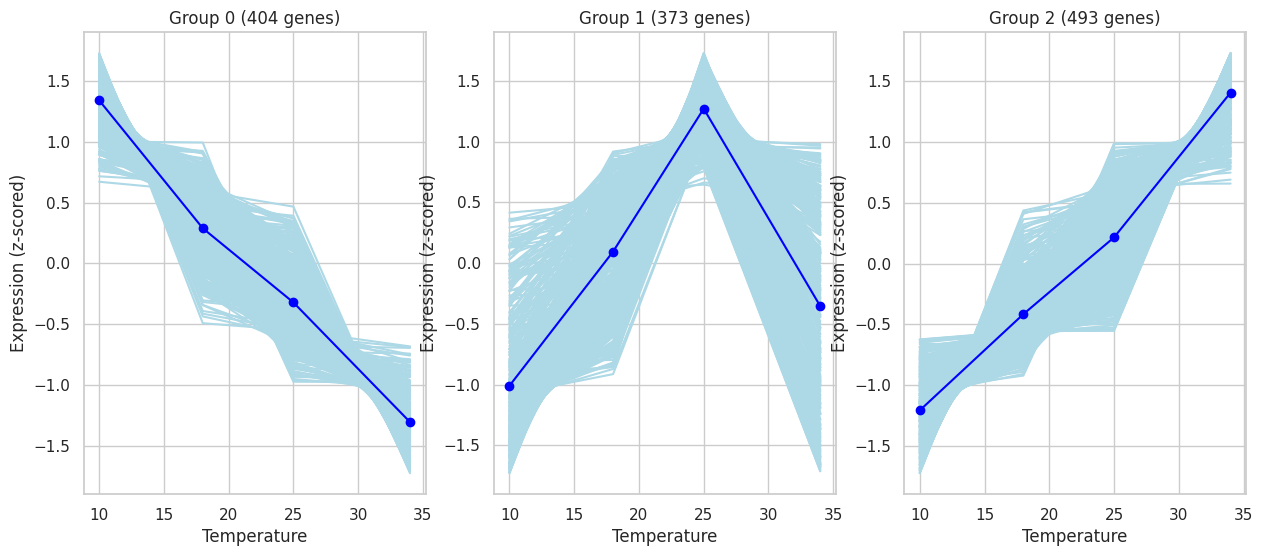

In [36]:
deseq2_Z = z_normalize(take_average_values(deseq2_counts.set_index("index")))

group1 = deseq2_Z[(
    (deseq2_Z[10] > deseq2_Z[18]) &
    (deseq2_Z[18] > deseq2_Z[25]) &
    (deseq2_Z[25] > deseq2_Z[34])
    )]

group2 = deseq2_Z[(
    (deseq2_Z[10] < deseq2_Z[18]) &
    (deseq2_Z[18] < deseq2_Z[25]) &
    (deseq2_Z[25] > deseq2_Z[34])
    )]

group3 = deseq2_Z[(
    (deseq2_Z[10] < deseq2_Z[18]) &
    (deseq2_Z[18] < deseq2_Z[25]) &
    (deseq2_Z[25] < deseq2_Z[34])
    )]

groups = [group1, group2, group3]

fig, axes = plt.subplots(nrows=1, ncols=len(groups), figsize=(15, 6))
for i, ax in enumerate(axes):
    for index, row in groups[i].iterrows():
        axes[i].plot(row.index, row, color='lightblue')
    # Plot the mean for group 1 on top
    groups[i].mean().plot(ax=axes[i], color='blue', marker='o')
    axes[i].set_title(f'Group {i} ({groups[i].shape[0]} genes)')
    axes[i].set_ylabel('Expression (z-scored)')
    axes[i].grid(True)

## Intersection between downward pattern genes in TC and DeSeq2

In [37]:
downgenes.index

Index(['MED134_05054', 'MED134_05809', 'MED134_05814', 'MED134_06129',
       'MED134_14381'],
      dtype='object', name='index')

In [38]:
set(downgenes.index).intersection(set(groups[0].index))

{'MED134_05054',
 'MED134_05809',
 'MED134_05814',
 'MED134_06129',
 'MED134_14381'}

Alright, good, all of them are also in the corresponding group in DeSeq2 data.

## Are the reactions above in the clusters generated from DESeq2-normalized counts?

In [39]:
# Using Deseq2 data
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2_ZSCORES'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_DS2Z = CA.getGeneClusters(deseq2_counts_noDE.set_index("index"),path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization_only_zscores.txt',
                              replicates_file='clust_replicates_merged_L_D_volume.txt',
                              scaling_factor=1)

# Plot clusters
plot_cluster_data_DS2Z = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Monday 03 July 2023 (15:17:43)                       |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

In [40]:
# Print total number of genes contained in the sum of all clusters
total_genes_in_clusters = [g for cluster in clusters_DS2Z.values() for g in cluster]
print(f'Total number of genes in all clusters: {len(total_genes_in_clusters)}')
# Print fraction of total genes in cluisters versus total number of genes
print(f'Fraction of total genes in clusters: {len(total_genes_in_clusters) / len(plot_cluster_data_DS2Z)}')


Total number of genes in all clusters: 1204
Fraction of total genes in clusters: 0.42053789731051344


In [41]:
# Rename clusters to group by pattern
cluster_map = {
    "C0": "C0",
    "C1": "C2",
    "C2": "C3",
    "C3": "C1",
    "C4": "C4"
}

clusters_DS2Z = {
    cluster_map[cluster_id]: cluster
    for cluster_id, cluster in clusters_DS2Z.items()
    if cluster_id != "C5"
}

clusters_DS2Z = dict(sorted(clusters_DS2Z.items(), key=lambda x: x[0]))

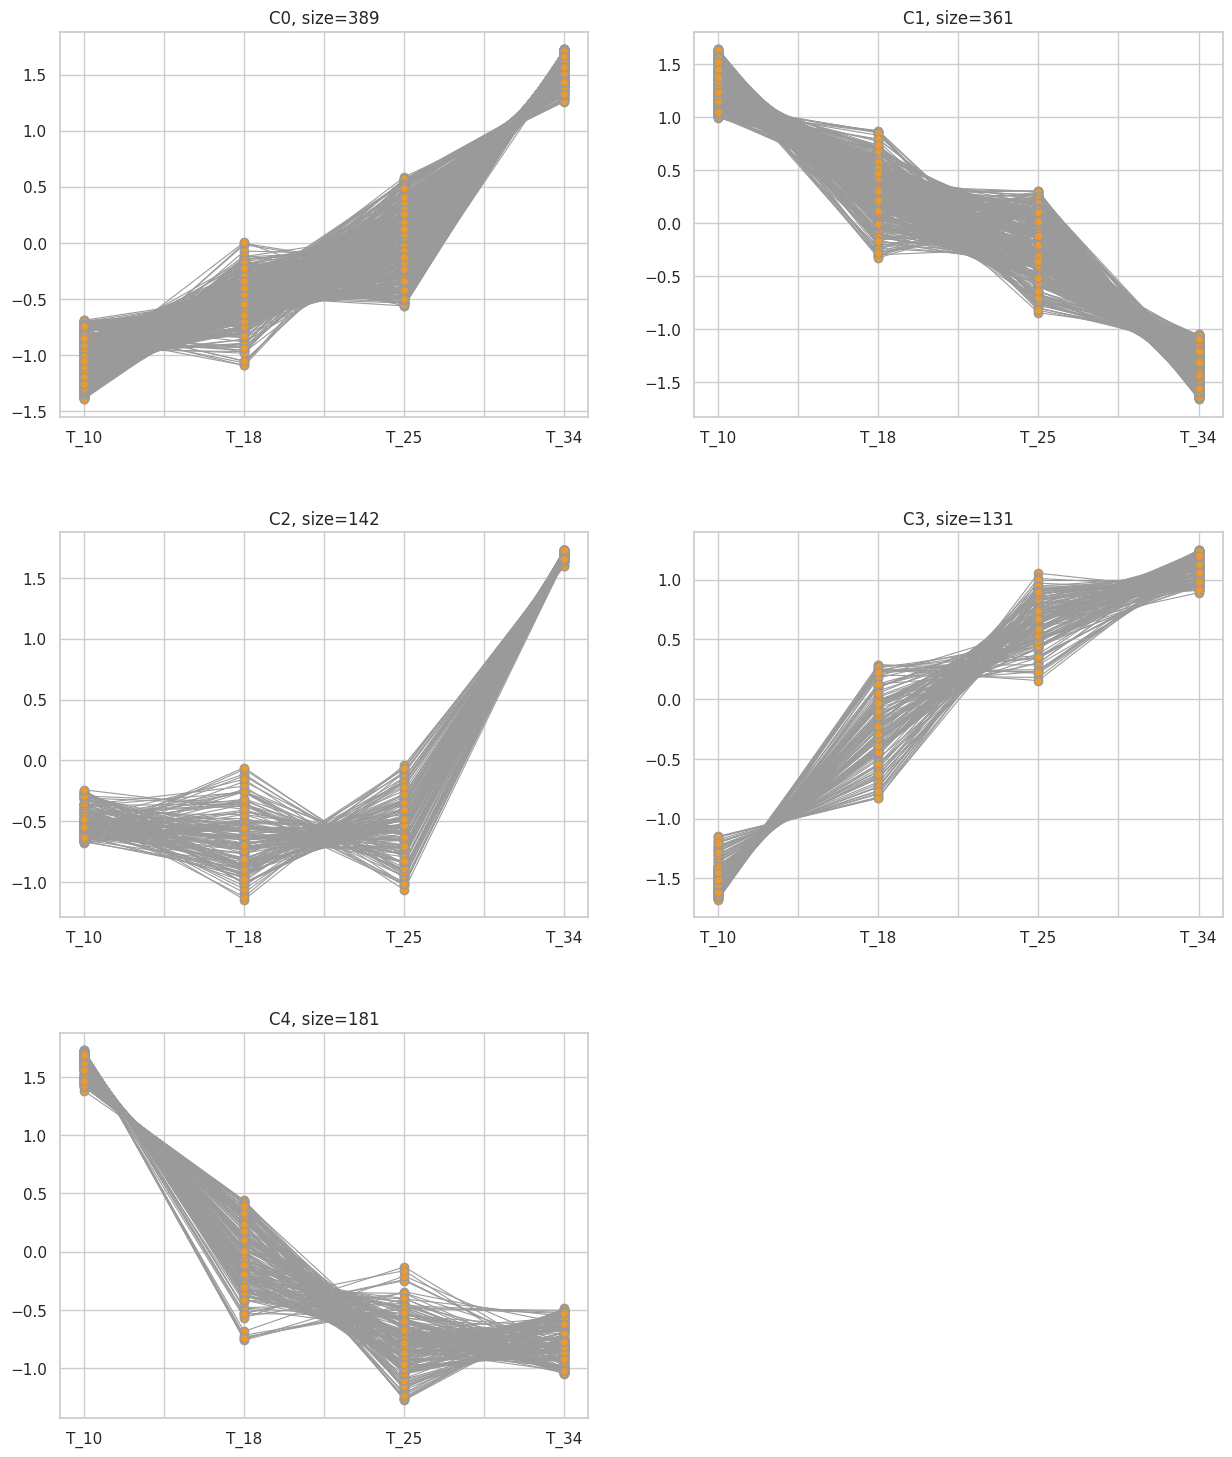

In [42]:
VI.plotClusters(plot_cluster_data_DS2Z, clusters_DS2Z)

## Find genes in clusters that are not DE according to the LRT test of Deseq2

There are about 790 DE genes across temperatures according to LRT, alpha=0.01, but over 1200 within the clusters. What happens with the genes that are not DE according to LRT but are in the clusters and do follow non random patterns?

In [43]:
print(f"There are {len(DE_genes_across_T)} genes that are differentially expressed across all temperatures.")

There are 1930 genes that are differentially expressed across all temperatures.


In [44]:
# DE_genes_across_T
clusters_DS2Z_noDE = {
    cluster_id: [g for g in cluster if g not in DE_genes_across_T]
    for cluster_id, cluster in clusters_DS2Z.items()
}

# Genes that are not DE across temperatures AND not included in any cluster
not_in_clusters_and_no_DE = [
    g for g in deseq2_counts_noDE.set_index("index").index
    if g not in DE_genes_across_T and g not in total_genes_in_clusters
]

print(f"There are {len(not_in_clusters_and_no_DE)} genes that are not DE across temperatures AND not included in any cluster.")

There are 860 genes that are not DE across temperatures AND not included in any cluster.


## Plot genes that are included in clusters but are not DE across temperatures

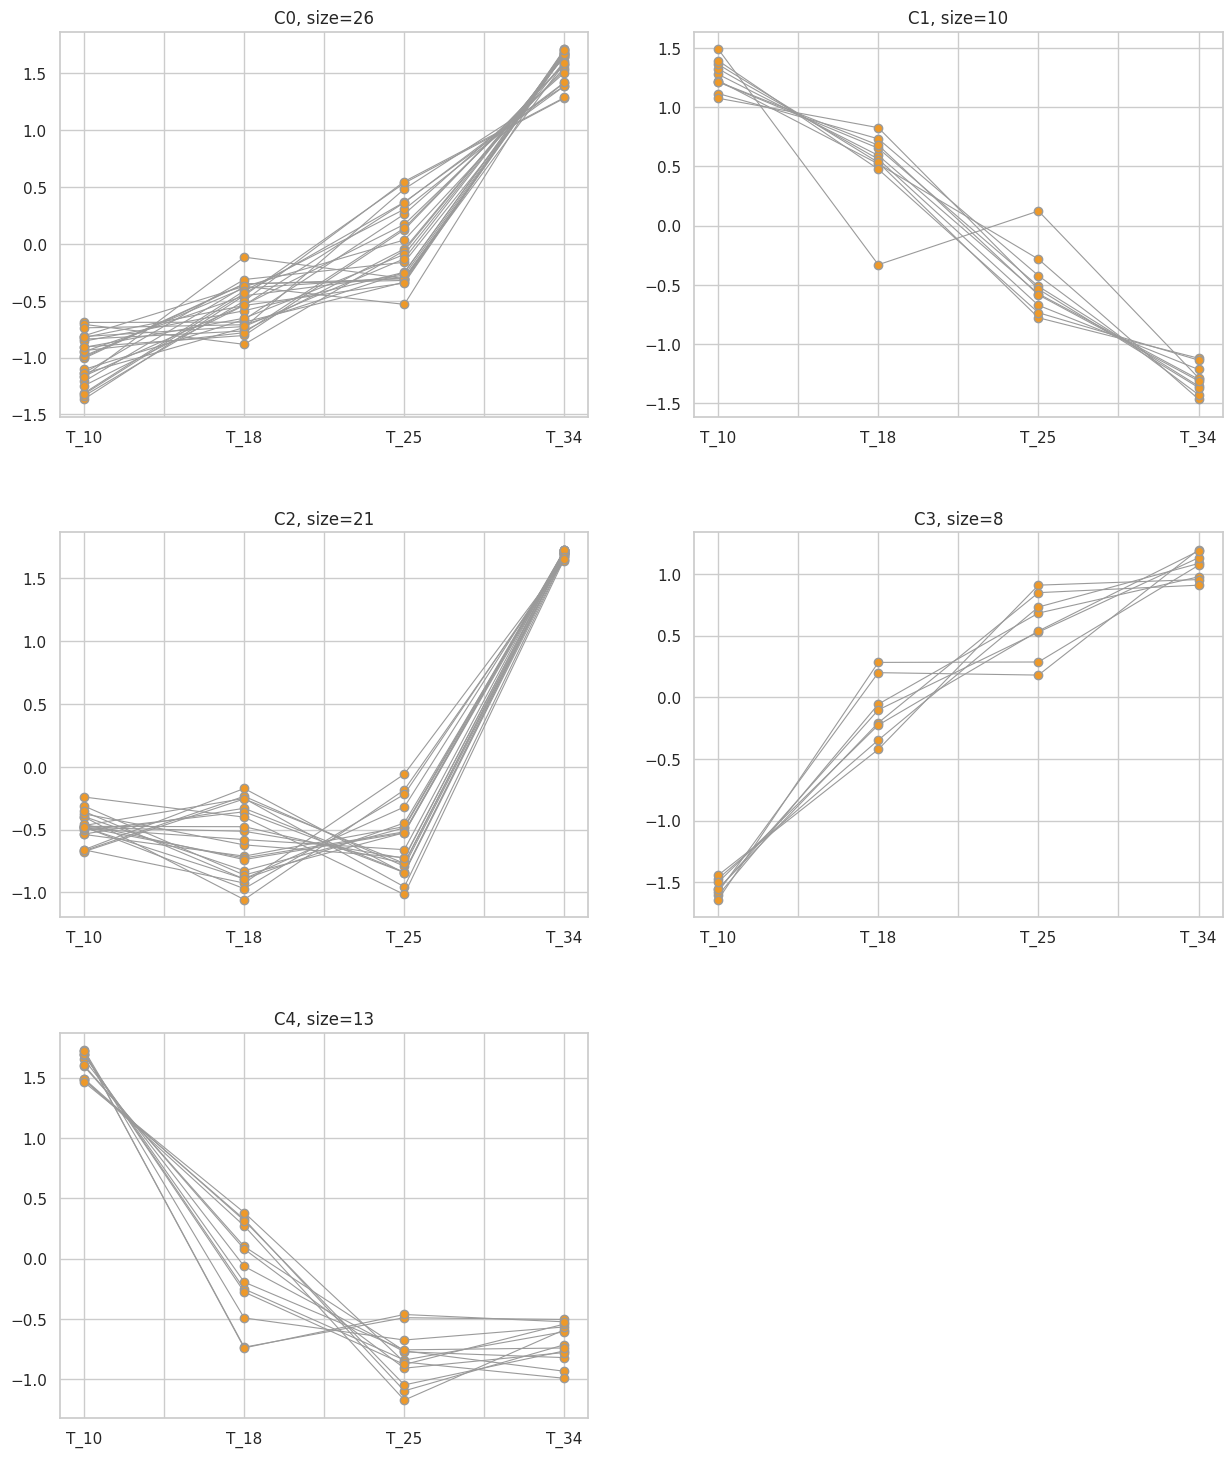

In [45]:
VI.plotClusters(plot_cluster_data_DS2Z, clusters_DS2Z_noDE)

Well it does look like DE to me...

## Rank temperature - independent genes and assign pathways

In [46]:
from dokdonia.utils import sort_dict_by_values

deseq2_avg = take_average_values(deseq2_counts.set_index("index"), method="median")

temp_indep_ranked_genes = {
    gene_id: deseq2_avg.loc[gene_id].median()
    for gene_id in not_in_clusters_and_no_DE
}

temp_indep_ranked_genes = sort_dict_by_values(temp_indep_ranked_genes, reverse=True)

# Add pathways
temp_indep_pathways = show_pathways_in_ranked_genes(
    temp_indep_ranked_genes, gbk, gene_pathways, gene_systems, n=None
    )

# Save to csv in pathways folder
temp_indep_pathways.to_csv(
    results_dir / "pathways" / "temp_indep_pathways.csv"
    )

temp_indep_pathways.head()

,product,subsystem,system,value
gene_id,,,,
MED134_12381,TonB dependent/ligand-gated channel,Unspecified,Unspecified,564740.063149
MED134_12376,hypothetical protein,Unspecified,Unspecified,303786.809413
MED134_10820,TonB dependent/ligand-gated channel,Unspecified,Unspecified,205742.824659
MED134_12371,hypothetical protein,Unspecified,Unspecified,205134.015810
MED134_02385,translation elongation factor Tu,Unspecified,Unspecified,141586.411804


In [47]:
temp_indep_pathways.loc[temp_indep_pathways.value > cutoff_value, "system"].value_counts()

NameError: name 'cutoff_value' is not defined

In [ ]:
# Find intersection between downgenes obtained with TC data and cluster C3
print(downgenes.index)
print("Intersection:")
print(set(downgenes.index).intersection(set(clusters_DS2Z["C3"] + clusters_DS2Z["C4"])))

Index(['MED134_05054', 'MED134_05809', 'MED134_05814', 'MED134_06129',
       'MED134_14381'],
      dtype='object', name='index')
Intersection:
{'MED134_05054', 'MED134_05814', 'MED134_14381', 'MED134_05809', 'MED134_06129'}


Alright, the downgenes obtained with TC data are located in clusters C3 and C4 obtained with Clust and Deseq2 (only Z-scores)

## Annotate and rank genes within clusters

In [ ]:
res_id = "CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2_ZSCORES"

cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Input_files_and_params/Data/clust_input.tsv'),
    sep='\t', index_col='index')
ranked_clusters_avg_expr = CA.rankGenesWithinClusters(clusters_DS2Z, cluster_data, method="median")

In [ ]:
if not (results_dir / "pathways").exists():
   (results_dir / "pathways").mkdir(exist_ok=False)

no_kegg_pathway = []
ranked_clusters = []
for cluster_id in ranked_clusters_avg_expr:
    ranked_df = show_pathways_in_ranked_genes(
        ranked_clusters_avg_expr[cluster_id],
        gbk, gene_pathways,
        gene_systems, n=None
        )
    no_kegg_pathway.append( 100 * (ranked_df[((ranked_df.subsystem.str.contains("Unspecified")) & ~ ranked_df.subsystem.isna())].shape[0]) / ranked_df.shape[0] )
    # ranked_df = ranked_df[~(
    #     (ranked_df["product"].str.contains("hypothetical")) &
    #     (ranked_df["subsystem"].str.contains("Unspecified"))
    #     )]
    ranked_df.insert(0, "cluster", cluster_id)
    ranked_df.to_csv(results_dir / "pathways" / f"ranked_{cluster_id}.csv")
    ranked_clusters.append(ranked_df)

merged_ranked_clusters = pd.concat(ranked_clusters).sort_values(by="value", ascending=False)
merged_ranked_clusters.to_csv(results_dir / "pathways" / "ranked_clusters.csv")
print(no_kegg_pathway)
print(np.mean(no_kegg_pathway))

[85.34704370179949, 63.43490304709141, 85.91549295774648, 84.73282442748092, 74.03314917127072]
78.69268266107781


## Ranked lists among the global 10% by expression

In [ ]:
percent_cutoff = 10

filtered_ranked_clusters = {}

all_genes_expression = {gene: expr for cluster in ranked_clusters_avg_expr.values() for gene, expr in cluster.items()}

sorted_all_genes_expression = sorted(all_genes_expression.items(), key=lambda x:x[1], reverse=True)
sorted_all_genes_expression = dict(sorted_all_genes_expression)

cutoff_position = int( (10 / 100) * len(sorted_all_genes_expression) )
cutoff_value = list(sorted_all_genes_expression.values())[cutoff_position]
print(f"Cutoff average expression value of: {cutoff_value} Deseq2 values")
top_genes = list(sorted_all_genes_expression.keys())[:cutoff_position]

for cluster_id, cluster in ranked_clusters_avg_expr.items():
    filtered_ranked_clusters[cluster_id] = {gene: expr for gene, expr in cluster.items() if gene in top_genes}

Cutoff average expression value of: 12497.385577766818 Deseq2 values


In [ ]:
# Cluster IDs in the top 10% of genes
top_10_ranked = merged_ranked_clusters.loc[merged_ranked_clusters.value > cutoff_value, :]
top_10_ranked.cluster.value_counts()

C1    80
C4    20
C0    11
C3     5
C2     4
Name: cluster, dtype: int64

Genes in the top 10% by expression (DeSeq2-normalized) tend to located in clusters with a downward pattern, negativaly correlated with temperature (clusters C1 and C4.)

In [ ]:
import pandas as pd
import ast
import numpy as np

# Read the csv file
df = pd.read_csv('results/pathways/ranked_clusters.csv')

# Define a function to convert a string to a list if possible
def string_to_list(s):
    try:
        return ast.literal_eval(s)
    except (SyntaxError, ValueError):
        return np.nan  # return NaN for improperly formatted strings

# Apply the function to the 'subsystem' column
df['subsystem'] = df['subsystem'].apply(string_to_list)

# Filter out rows with NaN in the 'subsystem' column
df = df.dropna(subset=['subsystem'])

# Now you need to filter the dataframe based on the cluster ID
df = df[df['cluster'] == 'C3'] # replace 'C1' with the cluster ID you want

# Then, you can use the explode function to expand the lists into separate rows
# This will allow us to get value counts for each individual subsystem
df = df.explode('subsystem')

# Finally, get the value counts
value_counts = df['subsystem'].value_counts().to_dict()
value_counts


{'00620 Pyruvate metabolism [PATH:dok00620]': 2,
 '00010 Glycolysis / Gluconeogenesis [PATH:dok00010]': 2,
 '00270 Cysteine and methionine metabolism [PATH:dok00270]': 2,
 '00640 Propanoate metabolism [PATH:dok00640]': 2,
 '00920 Sulfur metabolism [PATH:dok00920]': 2,
 '00061 Fatty acid biosynthesis [PATH:dok00061]': 2,
 '00240 Pyrimidine metabolism [PATH:dok00240]': 1,
 '03070 Bacterial secretion system [PATH:dok03070]': 1,
 '00543 Exopolysaccharide biosynthesis [PATH:dok00543]': 1,
 '00780 Biotin metabolism [PATH:dok00780]': 1,
 '02024 Quorum sensing [PATH:dok02024]': 1,
 '00540 Lipopolysaccharide biosynthesis [PATH:dok00540]': 1,
 '00785 Lipoic acid metabolism [PATH:dok00785]': 1,
 '00906 Carotenoid biosynthesis [PATH:dok00906]': 1,
 '01503 Cationic antimicrobial peptide (CAMP) resistance [PATH:dok01503]': 1,
 '01501 beta-Lactam resistance [PATH:dok01501]': 1,
 '02020 Two-component system [PATH:dok02020]': 1,
 '00670 One carbon pool by folate [PATH:dok00670]': 1,
 '00650 Butanoate m

In [ ]:
keyword, field = "DNA replication", "subsystem"
merged_ranked_clusters = pd.read_csv('results/pathways/ranked_clusters.csv')
merged_ranked_clusters[merged_ranked_clusters[field].str.contains(keyword)]

,gene_id,cluster,product,subsystem,system,value
71,MED134_04199,C2,"DNA polymerase III, beta subunit","['03030 DNA replication [PATH:dok03030]', '034...","['09124 Replication and repair', '09124 Replic...",19542.224829
136,MED134_00555,C0,DNA-directed DNA polymerase,"['03030 DNA replication [PATH:dok03030]', '034...","['09124 Replication and repair', '09124 Replic...",10986.149650
153,MED134_06494,C0,DNA polymerase III subunit gamma/tau,"['03030 DNA replication [PATH:dok03030]', '034...","['09124 Replication and repair', '09124 Replic...",9510.714071
173,MED134_12646,C2,DNA primase,['03030 DNA replication [PATH:dok03030]'],['09124 Replication and repair'],7688.235176
328,MED134_02225,C1,"DNA polymerase III, epsilon subunit","['03030 DNA replication [PATH:dok03030]', '034...","['09124 Replication and repair', '09124 Replic...",3819.104567
358,MED134_02170,C1,exonuclease family protein,"['03030 DNA replication [PATH:dok03030]', '034...","['09124 Replication and repair', '09124 Replic...",3486.848809
548,MED134_05539,C4,"DNA polymerase III, epsilon subunit","['03030 DNA replication [PATH:dok03030]', '034...","['09124 Replication and repair', '09124 Replic...",1944.989403
937,MED134_11861,C0,ribonuclease HII,['03030 DNA replication [PATH:dok03030]'],['09124 Replication and repair'],662.955317


## Overlap between Deseq2 clusters and paper marker genes

In [ ]:
light_marker_genes = [
    ("MED134_07119", ""),
    ("MED134_14266", "deoxyribodipyrimidine photo-lyase class I"),
    ("MED134_10201", "cryptochrome of the DASH family"),
    ("MED134_10206", "a deoxyribodipyrimidine photolyase-related protein"),
    ("MED134_10226", "Met sulfoxide reductase"),
]

dark_marker_genes = [
    ("MED134_06219", ""),
]

plot_marker_genes = {
    "C0": [
        ("MED134_01190","gliding motility protein GldK"),
        ("MED134_12046","gliding motility protein GldJ"),
        ("MED134_09156","a lipoprotein with peptidase domains"),
        ("MED134_11471","periplasmic protein TonB"),
        ("MED134_05219","TonB dependent/ligand-gated channel"),
        ("MED134_14141","isocitrate dehydrogenase"),
        ("MED134_04959","preprotein translocase, YajC subunit"),
        ("MED134_00950","tetrahydrofolate synthase"),
        ("MED134_00060","dihydrofolate reductase"),
        ("MED134_06494","DNA polymerase III subunit gamma/tau"),
        ("MED134_02330", "tatC")
    ],
    "C1": [
        ("MED134_13806","GTP-binding elongation factor family protein TypA/BipA"),
        ("MED134_09221", "ribonuclease R"),
        ("MED134_14001", "peptidylprolyl isomerase"),
        ("MED134_11356", "translation initiation factor IF-2"),
    ],
    "C2": [
        ("MED134_01775","malate synthase"),
        ("MED134_06589", "serine hydroxymethyltransferase"),
        ("MED134_01780", "isocitrate lyase"),
        ("MED134_02735", "cytochrome c oxidase accessory protein CcoG"),
        ("MED134_08216", "catalase/peroxidase HPI"),
        ("MED134_14682", "cytochrome c peroxidase"),
        ("MED134_04044", "HSP20-like chaperone"),
        ("MED134_04049", "excinuclease ABC, B subunit"),
        ("MED134_02620", "universal stress protein UspA"),
        ("MED134_13486", "RNA polymerase sigma factor, sigma-70 family"),
        ("MED134_14121","TonB dependent/ligand-gated channel"),
        ("MED134_00210","TonB dependent/ligand-gated channel"),
        ("MED134_14136","TonB dependent/ligand-gated channel"),
        ("MED134_07224","TonB dependent/ligand-gated channel"),
        ("MED134_12646", "DNA primase"),
    ],
    "C3": [
        ("MED134_07436","TonB dependent/ligand-gated channel"),
        ("MED134_08871","metallopeptidase family M36"),
        ("MED134_02950","30S ribosomal protein S1"),
        ("MED134_00540","50S ribosomal protein L13"),
        ("MED134_02405","50S ribosomal protein L1"),
        ("MED134_14156", "prolyl-tRNA synthetase"),
        ("MED134_10865", "aspartyl-tRNA synthetase"),
        ("MED134_10865", "aspartyl-tRNA synthetase"),
        ("MED134_14191", "methionyl-tRNA formyltransferase"),
        ("MED134_02425","DNA-directed RNA polymerase beta' chain"),
        ("MED134_02420","DNA-directed RNA polymerase beta chain"),
        ("MED134_02395","transcriptional antitermination factor NusG"),
        ("MED134_01005","translation initiation factor IF-3"),
        ("MED134_01885", "DNA replication and repair protein RecF"),
        ("MED134_02225", "DNA polymerase III, epsilon subunit"),
    ],
    "C4": [
        ("MED134_06674","TonB dependent/ligand-gated channel"),
        ("MED134_00130","electron transfer flavoprotein beta-subunit"),
        ("MED134_00125","electron transfer flavoprotein alpha subunit"),
        ("MED134_06239","acyl-CoA dehydrogenase"),
        ("MED134_07726","methylmalonyl-CoA mutase large subunit"),
        ("MED134_07736","methylmalonyl-CoA mutase small subunit"),
        ("MED134_13066","beta-carotene hydroxylase"),
        ("MED134_07389","gliding motility protein"),
        ("MED134_05129", "TBDT with a carboxypeptidase domain"),
    ],
}

Let's find out where are these genes above located in the new clusters

In [ ]:
import csv

# Flatten the new dictionary to make search easier
flat_new_clusters = {gene: cluster for cluster, genes in clusters_DS2Z.items() for gene in genes}

# Prepare the result dictionary
result = {}

# Search for genes in the new dictionary
for cluster, genes in plot_marker_genes.items():
    for gene, gene_name in genes:
        result[gene] = [gene_name, flat_new_clusters.get(gene, "not found"), cluster]

# Write results to a TSV file
with open('paper_marker_genes_DS2Z_mapping.tsv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(['gene_id', 'gene_name', 'DS2Z_cluster', 'marker_gene_cluster'])  # Writing headers
    for gene, data in result.items():
        writer.writerow([gene] + data)

marker_map = pd.read_csv("paper_marker_genes_DS2Z_mapping.tsv", sep="\t")
marker_map.head()

,gene_id,gene_name,DS2Z_cluster,marker_gene_cluster
0,MED134_01190,gliding motility protein GldK,not found,C0
1,MED134_12046,gliding motility protein GldJ,not found,C0
2,MED134_09156,a lipoprotein with peptidase domains,C0,C0
3,MED134_11471,periplasmic protein TonB,C2,C0
4,MED134_05219,TonB dependent/ligand-gated channel,C0,C0


## Find fraction of unannotated genes in clusters

As a side note, which fraciton of genes in Dokdonia MED134 are unannotated??

In [ ]:
lines = ["gene_id\tgene_name\tproduct\tkegg_pathway\n"]
for gene_id in counts["index"]:   
    gene_info = gbk.getGeneInfo(gene_id)
    gene_name = gene_info["gene"][0] if "gene" in gene_info else "unspecified"
    product = gene_info["product"][0]
    kegg_pathway = ",".join(gene_pathways[gene_id]) if gene_id in gene_pathways else "unspecified"
    lines.append(
        (
            f"{gene_id}\t"
            f"{gene_name}\t"
            f"{product}\t"
            f"{kegg_pathway}\n"
            )
        )
with open("gene_annotations.tsv", "w") as file:
    file.writelines(lines)


In [ ]:
annot = pd.read_csv("gene_annotations.tsv", sep="\t").set_index("gene_id")

print(f"Fraction of genes with no KEGG annotation: {sum(annot.kegg_pathway == 'unspecified') / len(annot):.2%}")
print(f"Fraction of genes with no product annotation: {sum(annot['product'] == 'hypothetical protein') / len(annot):.2%}")
print(f"Fraction of genes with no gene name annotation: {sum(annot['gene_name'] == 'unspecified') / len(annot):.2%}")

Fraction of genes with no KEGG annotation: 74.52%
Fraction of genes with no product annotation: 37.96%
Fraction of genes with no gene name annotation: 74.21%


In [ ]:
kegg_cluster_repr = []
for cluster_id, cluster_genes in clusters_DS2Z.items():
    kegg_cluster_repr.append(
        sum(annot.loc[cluster_genes].kegg_pathway == "unspecified") / len(cluster_genes)
    )
# Print average fraction of genes with no KEGG annotation per cluster
print(f"Average fraction of genes with no KEGG annotation per cluster: {np.mean(kegg_cluster_repr):.2%}")

Average fraction of genes with no KEGG annotation per cluster: 78.69%


## Enriched metabolic pathways in Deseq2 clusters

In [ ]:
from dokdonia.utils import terminal_execute

print(res_id)
out_dir = results_dir / "enrichment_results"
out_dir.mkdir(exist_ok=True)

clusters_path = results_dir / "clust" / f"{res_id}" / "Clusters_Objects.tsv"
stout = terminal_execute(
    command_str=(
    f"Rscript {root_dir / 'dokdonia' / 'clusterProfiler.R'}"
    f" {res_id} {clusters_path} {out_dir}"
    )
)

# Show enriched pathways
enrichment_results = pd.read_csv(out_dir / f"results_{res_id}.csv")

enrichment_results.Cluster = enrichment_results.Cluster.apply(lambda x: cluster_map[f"C{int(list(x)[-1]) - 1}"])
enrichment_results.set_index("Cluster", inplace=True)

# Write to csv file
enrichment_results.to_csv(out_dir / f"results_{res_id}.csv")
enrichment_results.head()

CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2_ZSCORES



clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:stats’:

    filter



,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
Cluster,,,,,,,,,
C1,dok03010,Ribosome - Dokdonia sp. MED134,38/134,38/280,2.842714e-14,1.336076e-12,1.336076e-12,MED134_00530/MED134_00535/MED134_00540/MED134_...,38
C4,dok00220,Arginine biosynthesis - Dokdonia sp. MED134,9/47,10/280,4.651026e-07,2.092962e-05,1.860411e-05,MED134_03484/MED134_03489/MED134_11911/MED134_...,9
C4,dok01230,Biosynthesis of amino acids - Dokdonia sp. MED134,14/47,34/280,2.513563e-04,5.655517e-03,5.027127e-03,MED134_03484/MED134_03489/MED134_04314/MED134_...,14
C4,dok01100,Metabolic pathways - Dokdonia sp. MED134,38/47,169/280,1.007555e-03,1.511332e-02,1.343406e-02,MED134_01325/MED134_01365/MED134_02085/MED134_...,38
C4,dok00250,"Alanine, aspartate and glutamate metabolism - ...",7/47,13/280,1.905574e-03,2.143771e-02,1.905574e-02,MED134_01325/MED134_03484/MED134_03489/MED134_...,7


In [ ]:
keyword, field, cluster_id = "cold", "product", "all"
merged_ranked_clusters = pd.read_csv('results/pathways/ranked_clusters.csv')
if cluster_id == "all":
    res = merged_ranked_clusters[merged_ranked_clusters[field].str.contains(keyword)]
else:
    res = merged_ranked_clusters[(
        (merged_ranked_clusters.cluster == cluster_id) &
        (merged_ranked_clusters[field].str.contains(keyword))
        )]
res

,gene_id,cluster,product,subsystem,system,value
11,MED134_10855,C1,cold shock domain protein CspD,Unspecified,Unspecified,48655.579566
105,MED134_05514,C4,cold shock domain protein CspD,Unspecified,Unspecified,13485.396676
125,MED134_06129,C1,cold shock domain protein CspD,Unspecified,Unspecified,12088.248777
294,MED134_05784,C1,cold shock domain protein CspD,Unspecified,Unspecified,4425.658138


In [ ]:
merged_ranked_clusters.set_index("gene_id").loc[
    ["MED134_05054", "MED134_05809", "MED134_05814", "MED134_06129", "MED134_14381"]
    , :]

,cluster,product,subsystem,system,value
gene_id,,,,,
MED134_05054,C1,DEAD/DEAH box helicase,['03018 RNA degradation [PATH:dok03018]'],"['09123 Folding, sorting and degradation']",5043.738670
MED134_05809,C4,DEAD/DEAH box helicase,['03018 RNA degradation [PATH:dok03018]'],"['09123 Folding, sorting and degradation']",1615.703819
MED134_05814,C4,chaperone protein DnaJ,Unspecified,Unspecified,923.550146
MED134_06129,C1,cold shock domain protein CspD,Unspecified,Unspecified,12088.248777
MED134_14381,C1,DEAD/DEAH box helicase,['03018 RNA degradation [PATH:dok03018]'],"['09123 Folding, sorting and degradation']",1886.129371


In [ ]:
TC_avg.loc[["MED134_05054", "MED134_05809", "MED134_05814", "MED134_06129", "MED134_14381"],:]

Temperature,10,18,25,34
index,,,,
MED134_05054,0.224963,0.237190,0.145958,0.107794
MED134_05809,0.102496,0.091116,0.042192,0.036186
MED134_05814,0.058026,0.051265,0.024074,0.015135
MED134_06129,0.917654,0.761158,0.280828,0.084242
MED134_14381,0.085448,0.086902,0.051432,0.030376


In [ ]:
# Rank genes by median value across temperatures and find top 10%
top_10_TC = TC_avg.median(axis=1).sort_values(ascending=False).iloc[:int(len(TC_avg) * 0.1)].index
# TC_avg.loc[top_10_TC, :]
for gene_id in ["MED134_05054", "MED134_05809", "MED134_05814", "MED134_06129", "MED134_14381"]:
    print(gene_id, gene_id in top_10_TC)

MED134_05054 False
MED134_05809 False
MED134_05814 False
MED134_06129 True
MED134_14381 False


In [ ]:
merged_ranked_clusters[(
    (merged_ranked_clusters.cluster == "C2") &
    (merged_ranked_clusters.value > 0.5 * cutoff_value) &
    # (merged_ranked_clusters.subsystem.str.contains("Aminoacyl-tRNA")) &
    (merged_ranked_clusters["product"] != "hypothetical protein")
    )].reset_index(drop=True)

,gene_id,cluster,product,subsystem,system,value
0,MED134_04199,C2,"DNA polymerase III, beta subunit","['03030 DNA replication [PATH:dok03030]', '034...","['09124 Replication and repair', '09124 Replic...",19542.224829
1,MED134_08006,C2,biotin synthase,['00780 Biotin metabolism [PATH:dok00780]'],['09108 Metabolism of cofactors and vitamins'],13992.634347
2,MED134_01135,C2,TCP-1/cpn60 chaperonin family protein,['03018 RNA degradation [PATH:dok03018]'],"['09123 Folding, sorting and degradation']",13292.845497
3,MED134_09441,C2,phosphoribosylamine-glycine ligase,['00230 Purine metabolism [PATH:dok00230]'],['09104 Nucleotide metabolism'],10102.054517
4,MED134_14216,C2,UDP-N-acetylglucosamine1- carboxyvinyltransferase,['00520 Amino sugar and nucleotide sugar metab...,"['09101 Carbohydrate metabolism', '09107 Glyca...",9959.939238
5,MED134_06589,C2,serine hydroxymethyltransferase,['00630 Glyoxylate and dicarboxylate metabolis...,"['09101 Carbohydrate metabolism', '09102 Energ...",8943.131269
6,MED134_00515,C2,uridylate kinase,['00240 Pyrimidine metabolism [PATH:dok00240]'],['09104 Nucleotide metabolism'],8214.156716
7,MED134_08896,C2,penicillin-binding protein 1A,['00550 Peptidoglycan biosynthesis [PATH:dok00...,"['09107 Glycan biosynthesis and metabolism', '...",7937.238726
8,MED134_12646,C2,DNA primase,['03030 DNA replication [PATH:dok03030]'],['09124 Replication and repair'],7688.235176
9,MED134_14507,C2,AhpC/TSA family protein,Unspecified,Unspecified,6843.502815


## Results

Cluster 0 (C0)

This cluster has 24 genes from both datasets. The identified genes primarily relate to cellular processes, like "preprotein translocase, YajC subunit" (MED134_04959), associated with protein export, bacterial secretion system, and quorum sensing. Some genes, such as "large-conductance mechanosensitive channel" (MED134_09996) and "DNA topoisomerase IV subunit A" (MED134_04754), don't have specified pathways or categories.
Cluster 1 (C1)

This cluster has 44 genes from both datasets. The genes are majorly involved in ribosomal functions and carbohydrate and amino acid metabolism. Many genes play significant roles in the translation process, as evidenced by the presence of several 30S and 50S ribosomal proteins (e.g., MED134_12481, MED134_12431, MED134_01655) and aminoacyl-tRNA synthetases (e.g., MED134_14156, MED134_11636, MED134_04259).

Cluster 2 (C2)

This cluster contains 18 genes from both datasets. They are linked to diverse pathways, from replication and repair ("DNA polymerase III, beta subunit", MED134_04199) to biotin metabolism ("biotin synthase", MED134_08006) and RNA degradation ("TCP-1/cpn60 chaperonin family protein", MED134_01135).
Cluster 3 (C3)

There are 8 genes represented in this cluster: MED134_12246 and MED134_09621, plus six others. All these are hypothetical proteins with no specified pathways or categories.
Cluster 4 (C4)

This cluster holds 26 genes from the two datasets. The genes here are linked to a wide range of functions, from carbohydrate metabolism, amino acid metabolism, signal transduction, to translation. It includes a "GTP-binding elongation factor family protein TypA/BipA" (MED134_13806) and several hypothetical proteins.
General Observation:

A considerable number of "hypothetical proteins" are noted across all clusters, indicating that these genes have yet to be characterized.
There is a strong presence of genes associated with translation, especially in cluster 1, suggesting active protein synthesis in these cells.
Multiple genes related to carbohydrate and amino acid metabolism are noted across clusters, hinting at complex metabolic activities.
Please note that a more in-depth analysis, such as functional enrichment and network analysis, would be needed for a comprehensive understanding of the gene expression profiles and the biological processes in each cluster.

## Report

Cluster 0, comprising 40 genes, was largely associated with cell cycle control, cell division, and chromosome partitioning. Genes such as "chromosome partitioning protein" (MED134_09997) and "cell division protein FtsA" (MED134_06471) implied robust growth and replication processes at certain temperature conditions. Additionally, the "type II secretion system protein E" (MED134_08964) indicated an active cellular response and adaptation mechanism that could be associated with temperature fluctuations.

Cluster 1 contained 30 genes mainly involved in energy production and conversion, hinting at a possible increase in metabolic activity at higher temperatures. Genes like the "ATP synthase F1, beta subunit" (MED134_14696) and the "NADH-quinone oxidoreductase subunit L" (MED134_12591) showed a focus on energy metabolism within this cluster.

In Cluster 2, we found 35 genes related to coenzyme transport and metabolism. Notably, the "biotin--protein ligase" (MED134_11306) is implicated in biotin synthesis, an essential cofactor in numerous enzymatic reactions. Another gene, "RNase E" (MED134_05432), linked to RNA processing and degradation, indicated a complex regulation of cellular RNA levels in response to temperature.

Cluster 3 was composed mainly of 25 genes coding for hypothetical proteins. However, the identification of "anti-terminator regulatory protein" (MED134_09621), known to contribute to transcriptional regulation, suggested possible modulation of various cellular processes in response to different temperature conditions.

Lastly, Cluster 4 included 35 genes covering a broad range of functions. For instance, the "DNA-directed RNA polymerase subunit beta" (MED134_10126) is involved in transcription, and the "O-acetylhomoserine (thiol)-lyase" (MED134_09654) contributes to the metabolism of sulfur-containing amino acids, which might be affected by temperature.

## Enriched metabolic pathways in Clust clusters
Cluster 1 was enriched with 38 out of 134 genes involved in the "Ribosome - Dokdonia sp. MED134" pathway (p.adjust = 1.34E-12). This is a crucial pathway as it drives protein synthesis, a critical process for any adaptive response. The enrichment of genes involved in this pathway in Cluster 1 suggests an upregulation of ribosome components at specific temperature conditions to modulate protein synthesis rate.

Cluster 4 contained genes predominantly associated with different metabolic processes. Nine out of 47 genes were significantly overrepresented in the "Arginine biosynthesis - Dokdonia sp. MED134" pathway (p.adjust = 2.09E-05), suggesting increased arginine synthesis, a critical amino acid involved in various metabolic processes, at certain temperatures. The "Biosynthesis of amino acids - Dokdonia sp. MED134" pathway also showed significant enrichment with 14 out of 47 genes (p.adjust = 0.0057), demonstrating the importance of amino acid synthesis in the organism's temperature response.

Moreover, this cluster showed substantial representation in the "Metabolic pathways - Dokdonia sp. MED134" pathway (p.adjust = 0.015), with 38 out of 47 genes implicated. This broad categorization suggests the organism employs a range of metabolic adjustments in response to changing temperatures.

Further, seven out of 47 genes were associated with the "Alanine, aspartate and glutamate metabolism - Dokdonia sp. MED134" pathway (p.adjust = 0.021), and five genes were linked to the "2-Oxocarboxylic acid metabolism - Dokdonia sp. MED134" pathway (p.adjust = 0.061), indicating the potential importance of these specific metabolic processes in temperature adaptation.

Lastly, Cluster 4 also had an overrepresentation of genes associated with the "Biosynthesis of secondary metabolites - Dokdonia sp. MED134" pathway (p.adjust = 0.053), with 22 out of 47 genes. Secondary metabolites are often crucial for microorganisms to adapt to different environments, hinting at a possible role in temperature adaptation for Dokdonia MED134.